# Monitoring Machine Learning Model in Production Using NannyML

In [1]:
# Import required packages
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier

import nannyml as nml

%matplotlib inline

In [41]:
df = pd.read_csv('../data/adult.csv', na_values='?')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [42]:
# Check data types
df.dtypes

age                 int64
workclass          object
fnlwgt              int64
education          object
educational-num     int64
marital-status     object
occupation         object
relationship       object
race               object
gender             object
capital-gain        int64
capital-loss        int64
hours-per-week      int64
native-country     object
income             object
dtype: object

In [43]:
# check the size of the data and missing values
print(f"Shape of data: {df.shape}")
print(f"Missing values in the data: {df.isnull().sum().sum()}")

Shape of data: (48842, 15)
Missing values in the data: 6465


In [44]:
# Drop the missing points and the fnlwgt column
df = df.dropna()
df = df.drop(['fnlwgt'], axis=1)
df.shape

(45222, 14)

In [45]:
# summarize the class distribution
target = df.income.values
counter = Counter(target)
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%s, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=<=50K, Count=34014, Percentage=75.216%
Class=>50K, Count=11208, Percentage=24.784%


In [46]:
df.shape

(45222, 14)

## Modifying the Adult Income Dataset

### Enriching the data

This step involves three steps:
- Feature engineering
- Adding a time dimension to the dataset
- Splitting the data into reference and analysis sets
- Specify a binary classification target

##### Feature Engineering

The machine learning algorithm cannot process categorical data values. It can only process numerical values. 
To fit the data into the prediction model, we need to convert categorical values to numerical ones. Before that, we will evaluate if any transformation on categorical columns is necessary. 

In [47]:
def preprocess_df(df):
   
    # select categorical and numerical features
    cat_ix = df.select_dtypes(include=['object', 'bool']).columns
    num_ix = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Apply LabelEncoder
    le = LabelEncoder()
    mapping_dict = {}
    for col in cat_ix:
        df[col] = le.fit_transform(df[col])

        le_name_mapping = dict(zip(le.classes_,
                               le.transform(le.classes_)))
        mapping_dict[col] = le_name_mapping
    
    return df
# Apply the function to create the required features and target

df = preprocess_df(df)

In [48]:
df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,9,13,2,9,5,2,0,0,0,40,4,0


###### Add a time element to the data

In [49]:
# Add timestamps using the index. We add timestamps at 30 minute interval.
timestamps = [dt.datetime(2020,1,1) + dt.timedelta(hours=x/2) for x in df.index]
df['timestamp'] = timestamps
df.tail()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,timestamp
48836,33,2,9,13,4,9,3,4,1,0,0,40,38,0,2022-10-14 10:00:00
48837,39,2,9,13,0,9,1,4,0,0,0,36,38,0,2022-10-14 10:30:00
48839,38,2,9,13,2,9,0,4,1,0,0,50,38,0,2022-10-14 11:30:00
48840,44,2,9,13,0,0,3,1,1,5455,0,40,38,0,2022-10-14 12:00:00
48841,35,3,9,13,2,3,0,4,1,0,0,60,38,1,2022-10-14 12:30:00


##### Partition the dataset into train, test, and production sets

In [50]:
df = df.reset_index()
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))

production_size = int(0.1 * len(df))

train_start = df.index[0]
train_end = train_size
test_start = train_end
test_end = test_start + test_size

# we use the incluse=left argument to exclude the last date in a partition
df.loc[df['index'].between(train_start, train_end, inclusive='left'), 'partition'] = 'train'
df.loc[df['index'].between(test_start, test_end, inclusive='left'), 'partition'] = 'test'
df['partition'] = df['partition'].fillna('production')
df = df.drop(['index'], axis=1)
df.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,timestamp,partition
0,39,5,9,13,4,0,1,4,1,2174,0,40,38,0,2020-01-01 00:00:00,train
1,50,4,9,13,2,3,0,4,1,0,0,13,38,0,2020-01-01 00:30:00,train
2,38,2,11,9,0,5,1,4,1,0,0,40,38,0,2020-01-01 01:00:00,train
3,53,2,1,7,2,5,0,2,1,0,0,40,38,0,2020-01-01 01:30:00,train
4,28,2,9,13,2,9,5,2,0,0,0,40,4,0,2020-01-01 02:00:00,train


### Train a machine learning model

In [51]:
# fit classifier

target = 'income'
meta = 'partition'
df_train = df[df['partition']=='train']
features = df.iloc[:,:-3].columns
clf = RandomForestClassifier(random_state=42)
clf.fit(df_train[features], df_train[target])
df['y_pred_proba'] = clf.predict_proba(df[features])[:,1]
df['y_pred'] = df['y_pred_proba'].map(lambda p: int(p >= 0.9))

# check roc auc score
for partition_name, partition_data in df.groupby('partition', sort=False):
    print(partition_name, roc_auc_score(partition_data[target], partition_data['y_pred_proba']))

train 0.9970171113193225
test 0.8930647626976937
production 0.8907062917893507


## Preparing the data for NannyML

Yes, this Nanny likes her data prepared!
You need to create the `reference` dataframe to represent the testing period and the `analysis` dataframe to represent the analysis (production) period. You will also create the `analysis_target` dataframe to hold the targets for the analysis period.

In [52]:
def data_for_nanny(df):
    df = df[df['partition']!='train'].reset_index(drop=True)
    df['partition'] = df['partition'].map({'test':'reference', 'production':'analysis'})
    df['identifier'] = df.index
    
    reference = df[df['partition']=='reference'].copy()
    analysis = df[df['partition']=='analysis'].copy()
    analysis_targets = analysis[['identifier', target]].copy()
    analysis = analysis.drop(target, axis=1)
    return reference, analysis, analysis_targets

In [53]:
# Now import the dataframes
reference, analysis, analysis_targets = data_for_nanny(df)
# check that everything is ok
reference.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income,timestamp,partition,y_pred_proba,y_pred,identifier
0,48,3,9,13,2,4,0,4,1,0,0,70,38,1,2021-10-21 11:30:00,reference,0.54,0,0
1,51,2,15,10,0,3,1,4,0,0,0,36,38,0,2021-10-21 12:00:00,reference,0.00,0,1
2,67,5,5,4,2,13,0,4,1,0,0,35,38,0,2021-10-21 12:30:00,reference,0.15,0,2
3,17,2,0,6,4,11,4,4,0,0,0,24,38,0,2021-10-21 13:00:00,reference,0.00,0,3
4,24,5,15,10,4,7,1,4,1,0,0,40,38,0,2021-10-21 13:30:00,reference,0.00,0,4


In [54]:
analysis.head()

,age,workclass,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,timestamp,partition,y_pred_proba,y_pred,identifier
8352,20,4,15,10,4,11,1,4,0,0,0,25,38,2022-04-27 21:30:00,analysis,0.000000,0,8352
8353,49,0,15,10,2,0,0,4,1,0,0,41,38,2022-04-27 22:00:00,analysis,0.277500,0,8353
8354,18,2,1,7,4,2,3,4,1,0,0,40,38,2022-04-27 22:30:00,analysis,0.000000,0,8354
8355,28,2,11,9,2,2,0,4,1,0,0,40,38,2022-04-27 23:00:00,analysis,0.104367,0,8355
8356,45,0,11,9,2,0,5,4,0,0,0,37,38,2022-04-27 23:30:00,analysis,0.750000,0,8356


In [55]:
analysis_targets.head()

,identifier,income
8352,8352,0
8353,8353,1
8354,8354,0
8355,8355,0
8356,8356,0


## Extract metadata and add target column name

Need to explain all this

In [56]:
# load_data
data = pd.concat([reference, analysis], ignore_index=True)

metadata = nml.extract_metadata(reference, exclude_columns=['identifier'], model_type='classification_binary')

# This is the target var that you want to predict
metadata.target_column_name = target

# specify the timestamp column_name
metadata.timestamp_column_name = 'timestamp'

## Performance Estimation


In [73]:
=

C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\nannyml\chunk.py:190: UserWarning:

The resulting list of chunks contains 1 underpopulated chunks. They contain too few records to be statistically robust and might negatively influence the quality of calculations. Please consider splitting your data in a different way or continue at your own risk.

C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\nannyml\chunk.py:190: UserWarning:

The resulting list of chunks contains 1 underpopulated chunks. They contain too few records to be statistically robust and might negatively influence the quality of calculations. Please consider splitting your data in a different way or continue at your own risk.



##### Compare with the actual performance

Let's use the ground truth to calculate ROC AUC on relevant chunks and compare.

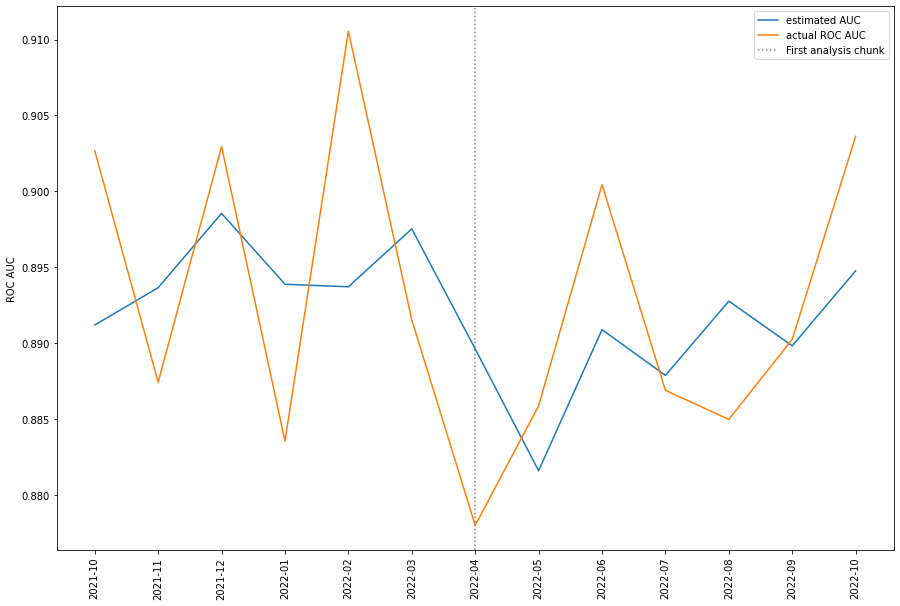

In [58]:
# add ground truth to analysis
analysis_full = pd.merge(analysis, analysis_targets, on = 'identifier')
df_all = pd.concat([reference, analysis_full]).reset_index(drop=True)
df_all['timestamp'] = pd.to_datetime(df_all['timestamp'])

# calculate actual ROC AUC
target_col = metadata.target_column_name
pred_score_col = 'y_pred_proba'
actual_performance = []


for idx in est_perf.data.index:
    start_date, end_date = est_perf.data.loc[idx , 'start_date'], est_perf.data.loc[idx, 'end_date']
    sub = df_all[df_all['timestamp'].between(start_date, end_date)]
    actual_perf = roc_auc_score(sub[target_col], sub[pred_score_col])
    est_perf.data.loc[idx, 'actual_roc_auc'] = actual_perf

# Create the plot
first_analyis = est_perf.data[est_perf.data['partition'] =='analysis']['key'].values[0]
plt.figure(figsize=(15,10))
plt.plot(est_perf.data['key'], est_perf.data['estimated_roc_auc'], label='estimated AUC')
plt.plot(est_perf.data['key'], est_perf.data['actual_roc_auc'], label='actual ROC AUC')
plt.xticks(rotation=90)
plt.axvline(x=first_analyis, label='First analysis chunk', linestyle=':', color='grey')
plt.ylabel('ROC AUC')
plt.legend()
plt.show()

NannyML's library accurately captures the significant drop in performance in the first chunks of the analysis period. In general, the library captures the overall trend quite well. The estimated performance has lower variance as compared to the actual performance.

##### Detect univariate feature drift

In [59]:
# Detect univariate feature drift
univariate_calculator = nml.UnivariateStatisticalDriftCalculator(model_metadata=metadata, chunk_size=chunk_size)
univariate_calculator.fit(reference_data=reference)
univariate_results = univariate_calculator.calculate(data=data)
# Rank features based on number of alerts
ranker = nml.Ranker.by('alert_count')
# Create table to show drift alerts
ranker.rank(univariate_results, metadata)

C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\nannyml\chunk.py:190: UserWarning:

The resulting list of chunks contains 48 underpopulated chunks. They contain too few records to be statistically robust and might negatively influence the quality of calculations. Please consider splitting your data in a different way or continue at your own risk.



,feature,number_of_alerts,rank
0,native-country,4,1
1,occupation,2,2
2,race,2,3
3,age,1,4
4,education,1,5
5,educational-num,1,6
6,relationship,1,7
7,workclass,0,8
8,marital-status,0,9
9,gender,0,10


In [61]:
# Plot the distribution results for features exhibiting drift
ranked_features = ranker.rank(univariate_results, model_metadata=metadata, only_drifting = True)

for feature in ranked_features.feature:
    figure = univariate_results.plot(kind='feature_distribution', feature_label=feature)
    figure.show()
    
# To run this for categorical and continous features use the code

'''
# Plot distribution drift results for continuous model inputs

for feature in metadata.continuous_features:
    figure = univariate_results.plot(kind='feature_distribution',feature_label=feature.label)
    figure.show()

# Plot distribution drift results for categorical model inputs
for feature in metadata.categorical_features:
    figure = univariate_results.plot(kind='feature_distribution',feature_label=feature.label)
    figure.show()

'''

In [62]:
##### Detect multivariate feature drift

# Detect multivariate feature drift
multivariate_calculator = nml.DataReconstructionDriftCalculator(model_metadata=metadata, chunk_size=chunk_size)
multivariate_calculator.fit(reference_data=reference)
multivariate_results = multivariate_calculator.calculate(data=data)

figure = multivariate_results.plot(kind='drift')
figure.show()

C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\nannyml\chunk.py:190: UserWarning:

The resulting list of chunks contains 1 underpopulated chunks. They contain too few records to be statistically robust and might negatively influence the quality of calculations. Please consider splitting your data in a different way or continue at your own risk.



##### Detecting drift for model output

In [65]:
# Model output drift
figure = univariate_results.plot(kind='prediction_drift', metric='statistic')
figure.show()

In [74]:
figure = univariate_results.plot(kind='prediction_distribution', metric='statistic')
figure.show()

##### Target Drift

In [67]:
data = pd.concat([reference, analysis.set_index('identifier').join(analysis_targets.set_index('identifier'), on='identifier', rsuffix='_r')], ignore_index=True).reset_index(drop=True)
target_distribution_calculator = nml.TargetDistributionCalculator(model_metadata=metadata, chunk_size=chunk_size)
target_distribution_calculator = target_distribution_calculator.fit(reference_data=reference)
target_distribution = target_distribution_calculator.calculate(data)
target_distribution.data.head()

C:\Users\DELL\AppData\Local\Programs\Python\Python310\lib\site-packages\nannyml\chunk.py:190: UserWarning:

The resulting list of chunks contains 1 underpopulated chunks. They contain too few records to be statistically robust and might negatively influence the quality of calculations. Please consider splitting your data in a different way or continue at your own risk.



,key,start_index,end_index,start_date,end_date,partition,targets_missing_rate,metric_target_drift,statistical_target_drift,p_value,thresholds,alert,significant
0,[0:335],0,335,2021-10-21 11:30:00,2021-10-29 04:30:00,reference,0.0,0.264881,0.660407,0.416416,0.05,False,False
1,[336:671],336,671,2021-10-29 05:00:00,2021-11-05 18:00:00,reference,0.0,0.252976,0.099339,0.752625,0.05,False,False
2,[672:1007],672,1007,2021-11-05 18:30:00,2021-11-13 10:00:00,reference,0.0,0.229167,0.304707,0.580946,0.05,False,False
3,[1008:1343],1008,1343,2021-11-13 10:30:00,2021-11-20 23:00:00,reference,0.0,0.238095,0.031665,0.858766,0.05,False,False
4,[1344:1679],1344,1679,2021-11-20 23:30:00,2021-11-28 12:00:00,reference,0.0,0.261905,0.473819,0.491235,0.05,False,False


In [68]:
fig = target_distribution.plot(kind='distribution', distribution='metric')
fig.show()

In [69]:
fig = target_distribution.plot(kind='distribution', distribution='statistical')
fig.show()